In [4]:
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from scipy.optimize import fmin_l_bfgs_b

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In this script, we will focus on generating an image
with the same style as the input image.
But NOT the same content.
It should capture only the essence of the style.

In [5]:
def VGG16_AvgPool(shape):
    # we want to account for features across the entrie image
    # so we get rid of the maxpool which throws away information
    vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)
    
    new_model = Sequential()
    for layer in vgg.layers:
        if layer.__class__ == MaxPooling2D:
            # replace it with average pooling
            new_model.add(AveragePooling2D())
        else:
            new_model.add(layer)
    return new_model

In [6]:
def unpreprocess(img):
    # un-preprocess image from keras vgg which subtract mean
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [7]:
def gram_matrix(img):
    # input is (H, W, C) (C = # features)
    # we first need to convert it to (C, H*W)
    X = K.batch_flatten(K.permute_dimensions(img, (2, 0, 1)))
    # calculate the gram matrix
    # gram = XX^T / N
    # the constant is not important since we'll be weighting these
    G = K.dot(X, K.transpose(X)) / img.get_shape().num_elements()
    return G

In [8]:
def style_loss(y, t):
    return K.mean(K.square(gram_matrix(y) - gram_matrix(t)))

In [9]:
def minimize(fn, epochs, batch_shape):
    losses = []
    x = np.random.randn(np.prod(batch_shape))
    for i in range(epochs):
        x, l, _ = fmin_l_bfgs_b(
            func=fn,
            x0=x,
            maxfun=20
        )
        x = np.clip(x, -127, 127)
        print("iter=", i, ',', 'loss=', l)
        losses.append(l)
        
    plt.plot(losses)
    
    newimg = x.reshape(*batch_shape)
    final_img = unpreprocess(newimg)
    return final_img[0]

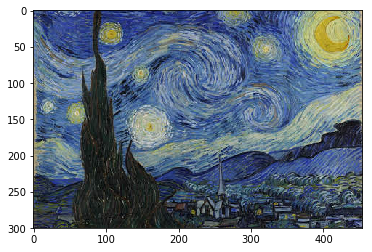

In [10]:
path = './data/styles/starrynight.jpg'
img = image.load_img(path)
plt.imshow(img)

In [11]:
# convert image to array and preprocess for vgg
x = image.img_to_array(img)
print(x.shape)
# make it (1, H, W, C)
x = np.expand_dims(x, axis=0)
print(x.shape)
x = preprocess_input(x)
print(x.shape)

(300, 454, 3)
(1, 300, 454, 3)
(1, 300, 454, 3)


In [12]:
batch_shape = x.shape
shape = x.shape[1:]

In [13]:
# let's take the first convolution at each block of convolutions
# to be our target outputs
vgg = VGG16_AvgPool(shape)
print(vgg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 300, 454, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 454, 64)      36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, 150, 227, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 227, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 227, 128)     147584    
_________________________________________________________________
average_pooling2d_2 (Average (None, 75, 113, 128)      0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 75, 113, 256)      295168    
__________

In [27]:
# Note: need to select output at index 1, since outputs at
# index 0 correspond to the original vgg with maxpool
symbolic_conv_outputs = [
    layer.get_output_at(1) for layer in vgg.layers if layer.name.endswith('conv1')
]

In [34]:
# pick the earlier layers for
# a more "localized" representation
# this is opposed to the content model
# where the later layers represent a more "global" structure
# symbolic_conv_outputs = symbolic_conv_outputs[:2]

In [40]:
# make a big model that outputs multiple layers's outputs
multi_output_model = Model(vgg.input, symbolic_conv_outputs)

In [41]:
# calculate the targets that are output at each layer
style_layers_outputs = [K.variable(y) for y in
                            multi_output_model.predict(x)]

In [42]:
# calculate the total style loss
loss = 0
for symbolic, actual in zip(symbolic_conv_outputs, style_layers_outputs):
    # gram_matrix() expects a (H, W, C) as input
    loss += style_loss(symbolic[0], actual[0])

In [43]:
grads = K.gradients(loss, multi_output_model.input)
get_loss_and_grads = K.function(
    inputs=[multi_output_model.input],
    outputs=[loss] + grads
)
def get_loss_and_grads_wrapper(x_vec):
    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])
    return l.astype(np.float64), g.flatten().astype(np.float64)

iter= 0 , loss= 5793.65869140625
iter= 1 , loss= 236.61898803710938
iter= 2 , loss= 97.71456146240234
iter= 3 , loss= 63.22955322265625
iter= 4 , loss= 40.59492874145508
iter= 5 , loss= 25.29944610595703
iter= 6 , loss= 14.36585807800293
iter= 7 , loss= 9.370770454406738
iter= 8 , loss= 6.301311492919922
iter= 9 , loss= 4.809230327606201


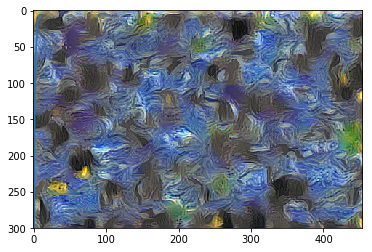

In [44]:
final_img = minimize(get_loss_and_grads_wrapper, 10, batch_shape)
plt.imshow(scale_img(final_img))